In [75]:
#Importing needed libraries
import requests
import pandas as pd
from datetime import datetime
import geopandas as gpd
import fiona
import time
from json import JSONDecodeError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from personal_lib import general_functions as gf
import re
from typing import Optional, List, Tuple
import googlemaps
import os
import math
import pyogrio
import geopandas as gpd
import io
from shapely import wkt
from matplotlib.patches import Patch




# Reading in the Prepped Data from parts 1 and 2 

In [2]:

### Reading in differen building data slices from Part 1 
buildings_data_2010_2017_canopy = pd.read_csv("building_final_2010_2017_canopy_20251116.csv")
# buildings_data_all_years_canopy = pd.read_csv("building_final_all_yrs_canopy_20251116.csv")
# max_buildings_no_footprint_2010_2017 = pd.read_csv('max_buildings_no_footprint_2010_2017_20251116.csv')
# max_buildings_no_footprint_all_years = pd.read_csv('max_buildings_no_footprint_all_years_20251116.csv')

## Starting with the buildings_data_2010_2017_canopy

### Limiting to those that have EUI values 

In [3]:
## Limiting to the columnd relevant for the analysis
core_columns = ['year_ending_year', 'property_id', 'bbl', 'address_1', 'address_2', 'city','boroname','ct2010',
                'latitude', 'longitude','geocode_key',
                'year_built','NumFloors','UnitsRes', 'stories','weather_normalized_site_eui',  'canopy_change_class',
               'construction_year', 'ground_elevation','height_roof']
## We need the main var to be present
print(buildings_data_2010_2017_canopy.shape)
working_buildings_bbls = buildings_data_2010_2017_canopy['bbl'][~buildings_data_2010_2017_canopy["weather_normalized_site_eui"].isnull()].unique()
working_buildings = buildings_data_2010_2017_canopy[buildings_data_2010_2017_canopy['bbl'].isin(working_buildings_bbls)]
print(working_buildings.shape)
## Need to confirm we have bbls that exist in every year. 
# working_buildings_lim = working_buildings[core_columns]

(6888, 82)
(6880, 82)


In [4]:
print(working_buildings.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))

                                       bbl
canopy_change_class year_ending_year      
Gain                2010               202
                    2017               202
Loss                2010               107
                    2017               107
No Change           2010              1093
                    2017              1093


In [5]:
### There are instances of multiple variations of the addresses in here for each BBL 
mult_address = working_buildings.groupby(['bbl']).agg({"address_1":"nunique"}).reset_index()
multiple_addresses = mult_address[mult_address['address_1']>1]
for_cleaning = working_buildings[["bbl","address_1","address_2","city"]][working_buildings["bbl"].isin(multiple_addresses['bbl'].unique())].drop_duplicates().sort_values(by='bbl')
## kicking out to CSV for manual cleaning of each address in excel 
# for_cleaning.to_csv("for_cleaning.csv",index=False)
## Reading Cleaned FIle back in 
cleaned = pd.read_csv('for_cleaning.csv', encoding='cp1252')

In [6]:
### Fixing the Working buildings Df 
single_enrty = working_buildings[~working_buildings['bbl'].isin(multiple_addresses['bbl'].unique())]
multi_entry = working_buildings[working_buildings['bbl'].isin(multiple_addresses['bbl'].unique())]


In [7]:
multi_entry_fixed = multi_entry.merge(for_cleaning, on=['bbl'])
multi_entry_fixed['address_1'] = multi_entry_fixed['address_1_y'].combine_first(multi_entry_fixed['address_1_x'])
multi_entry_fixed['address_2'] = multi_entry_fixed['address_2_y'].combine_first(multi_entry_fixed['address_2_x'])
multi_entry_fixed['city']= multi_entry_fixed['city_y'].combine_first(multi_entry_fixed['city_x'])
multi_entry_fixed = multi_entry_fixed.drop(columns=["address_1_x","address_1_x","city_x","address_1_y","address_1_y","city_y"])
#Finalized working buildings 
working_buildings_cleaned_addresses = pd.concat([single_enrty,multi_entry_fixed])

In [8]:
# working_buildings_cleaned_addresses
print(working_buildings_cleaned_addresses.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(working_buildings_cleaned_addresses.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"count"}))
## There are other issues here for multiple rows, hodling off on further cleaning because we will be doing more data triming before modeling

                                       bbl
canopy_change_class year_ending_year      
Gain                2010               202
                    2017               202
Loss                2010               107
                    2017               107
No Change           2010              1093
                    2017              1093
                                       bbl
canopy_change_class year_ending_year      
Gain                2010               780
                    2017               577
Loss                2010               397
                    2017               292
No Change           2010              4202
                    2017              3043


### Using the Footprint Geom for spatial join with trees. 

In [9]:
## Same Year limit on trees
trees_data = pd.read_csv("trees_processed_for_part3.csv")
print(trees_data.shape)
working_trees = trees_data[((trees_data["manual_year"].isin([2010,2017]))
                            &((trees_data['include_in_year']==True) | (trees_data['include_in_year'].isnull())))]
print(working_trees.shape)

C:\Users\johnf\AppData\Local\Temp\ipykernel_67620\159319654.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_data = pd.read_csv("trees_processed_for_part3.csv")


(5569204, 22)
(1391222, 22)


In [10]:
# starting from your building DF
bdf = working_buildings_cleaned_addresses.copy()
bdf["geometry"] = bdf["geometry"].apply(wkt.loads)

# 2) Wrap as GeoDataFrame, NYC coords in feet (EPSG:2263)
buildings_gdf = gpd.GeoDataFrame(bdf, geometry="geometry", crs="EPSG:2263")

# 3) Add a 50 ft buffer around each building footprint
buildings_buffered = buildings_gdf.copy()
buildings_buffered["geometry"] = buildings_buffered.geometry.buffer(50)

In [11]:
# points_df: regular pandas DataFrame with latitude / longitude columns
trees_gdf = gpd.GeoDataFrame(
    working_trees,
    geometry=gpd.points_from_xy(working_trees["lon"], working_trees["lat"]),
    crs="EPSG:4326"        # WGS84 (typical for lat/long)
)
# project points into the same CRS as buildings (feet)
trees_gdf_2263 = trees_gdf.to_crs(buildings_buffered.crs)

points_with_buildings = gpd.sjoin(
    trees_gdf_2263,
    buildings_buffered[["bbl", "geometry"]],  # plus any building cols you want
    how="left",          # keep all points, add building info where it matches
    predicate="within"   # point is within buffered building polygon
)

In [12]:
trees_near_buildings = points_with_buildings[points_with_buildings["bbl"].notna()].copy()
print("Trees near buildings:", len(trees_near_buildings))
trees_near_buildings.head()

Trees near buildings: 274118


,objectid,dbh,tpstructure,tpcondition,plantingspaceglobalid,geometry,globalid,genusspecies,createddate,location,...,planteddate,lat,lon,removal_date_est,removed_before_2018,removal_year,include_in_year,manual_year,index_right,bbl
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1248.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1249.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,1250.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,6044.0,1.018360e+09
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT (994673.637 228776.393),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010,6045.0,1.018360e+09


In [13]:
trees_near_buildings = trees_near_buildings[((trees_near_buildings['include_in_year'].isnull())
                                             |(trees_near_buildings['include_in_year']==True))].copy()
building_trees_grouped = trees_near_buildings.groupby(['manual_year','bbl','genusspecies']).agg({'objectid':'nunique'}).reset_index()
building_trees_grouped = building_trees_grouped.rename(columns={"objectid":"tree_count"})

In [14]:
building_trees_grouped.shape #(16054, 4)

(16054, 4)

In [15]:
building_trees_all = working_buildings.merge(building_trees_grouped,
                                          how='inner',
                                          right_on=['manual_year','bbl'],left_on = ['year_ending_year','bbl'])

In [16]:
building_trees_all.shape #(38705, 85)

(38705, 85)

In [17]:
##Checking this along the way
print(building_trees_all.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"count"}))

                                       bbl
canopy_change_class year_ending_year      
Gain                2010               199
                    2017               199
Loss                2010               104
                    2017               104
No Change           2010              1083
                    2017              1083
                                        bbl
canopy_change_class year_ending_year       
Gain                2010               3170
                    2017               2370
Loss                2010               1499
                    2017               1086
No Change           2010              17277
                    2017              13281


### limiting the columns to those that a needed for modeling / analysis. Dropping unusable 

In [18]:
building_trees_all_lim =building_trees_all[["year_ending_year","ct2010","bbl",'year_built','BldgClass','NumFloors', 'UnitsRes', 'stories',"construction_year",
                   "ground_elevation","height_roof","weather_normalized_site_eui","canopy_change_class","genusspecies","tree_count"]].drop_duplicates()
building_trees_all_lim = building_trees_all_lim.rename(columns={"year_ending_year":"year"})
building_trees_all_lim["year_built"] = building_trees_all_lim["year_built"].combine_first(building_trees_all_lim["construction_year"])
## Singluwer Null building for Num floors
building_trees_all = building_trees_all[~building_trees_all['NumFloors'].isnull()]
building_trees_all_lim = building_trees_all_lim.drop(columns=["construction_year"])

In [19]:
##Checking this along the way
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                           bbl
canopy_change_class year      
Gain                2010   199
                    2017   199
Loss                2010   104
                    2017   104
No Change           2010  1083
                    2017  1083
                           bbl
canopy_change_class year      
Gain                2010  1166
                    2017  1198
Loss                2010   587
                    2017   598
No Change           2010  6467
                    2017  6580


### Enriching for those that have null year built vals

In [20]:
## Manual Filling in these values 
need_year_bbl = list(building_trees_all_lim['bbl'][building_trees_all_lim["year_built"].isnull()].unique())

# build the SoQL WHERE clause:  bbl IN ('...', '...', ...)
where_clause = "bbl IN ({})".format(
    ",".join(f"'{b}'" for b in need_year_bbl)
)

url = "https://data.cityofnewyork.us/resource/64uk-42ks.json"

params = {
    "$select": "*",         # or pick specific columns
    "$where": where_clause
    # you can also add "$limit": 50000 if you want
}

resp = requests.get(url, params=params)
resp.raise_for_status()

rows = resp.json()
df = pd.DataFrame(rows)

print(df.head())
print(df.shape)


  borough block  lot   cd  ct2010 cb2010 schooldist council zipcode firecomp  \
0      MN   773  134  104      91   3000          2       3   10011     E001   
1      MN  1624   45  111  158.02   1000          2       8   10029     E053   
2      BX  2407   23  203     141   3003          7      17   10451     L055   
3      BX  2526   90  204     199   4002          9      16   10452     E068   
4      BX  2880  135  205  205.01   3000          9      14   10453     L059   

   ...               appbbl                  appdate plutomapid version  \
0  ...  1007730034.00000000  2003-01-09T00:00:00.000          1    25v3   
1  ...  1016240045.00000000  2002-03-14T00:00:00.000          1    25v3   
2  ...  2024070023.00000000  2011-03-02T00:00:00.000          1    25v3   
3  ...                  NaN                      NaN          1    25v3   
4  ...                  NaN                      NaN          1    25v3   

  sanitdistrict healthcenterdistrict  bct2020    bctcb2020 overlay1 

### Normalize BBL keys on BOTH dataframes as strings


In [21]:
# building_trees_all_lim: bbl is already int or numeric
building_trees_all_lim["bbl_key"] = (
    pd.to_numeric(building_trees_all_lim["bbl"], errors="coerce")
      .astype("Int64")
      .astype(str)
)

# df from the API: values like '1007730134.00000000'
df["bbl_key"] = (
    pd.to_numeric(df["bbl"], errors="coerce")   # turn '1007730134.00000000' into 1007730134
      .astype("Int64")
      .astype(str)
)

# 2. Build mapping bbl_key -> yearbuilt
bbl_to_yearbuilt = (
    df.groupby("bbl_key")["yearbuilt"]
      .first()          # or max/min if you prefer
)

# 3. Map into the building dataframe and fill only null year_built
mapped_years = building_trees_all_lim["bbl_key"].map(bbl_to_yearbuilt)

building_trees_all_lim["year_built"] = (
    building_trees_all_lim["year_built"]
      .fillna(mapped_years)
)

# (optional) ensure year_built is numeric
building_trees_all_lim["year_built"] = pd.to_numeric(
    building_trees_all_lim["year_built"], errors="coerce"
)


In [22]:
building_trees_all_lim['year_built'] = building_trees_all_lim['year_built'].astype(int)
building_trees_all_lim = building_trees_all_lim.drop(columns=['bbl_key'])

In [23]:
##Checking this along the way
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                           bbl
canopy_change_class year      
Gain                2010   199
                    2017   199
Loss                2010   104
                    2017   104
No Change           2010  1083
                    2017  1083
                           bbl
canopy_change_class year      
Gain                2010  1166
                    2017  1198
Loss                2010   587
                    2017   598
No Change           2010  6467
                    2017  6580


### Last Minute Filters for Data Cleaning




In [24]:
## No null EUI Values
null_eui_bbls = building_trees_all_lim['bbl'][building_trees_all_lim['weather_normalized_site_eui'].isnull()].unique()
building_trees_all_lim= building_trees_all_lim[~building_trees_all_lim['bbl'].isin(null_eui_bbls)]
## One off fix (from bellw)
building_trees_all_lim['year_built'][building_trees_all_lim['bbl'].isin([1007970007])]=2005


C:\Users\johnf\AppData\Local\Temp\ipykernel_67620\4029850022.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  building_trees_all_lim['year_built'][building_trees_all_lim['bbl'].isin([1007970007])]=2005


In [25]:
### Aggregate up one more level because i think the genius / species information is superfluous for now 
building_trees_all_lim_trees = building_trees_all_lim.groupby(['year', 'ct2010', 'bbl', 'year_built', 'BldgClass',
                                                               'NumFloors','canopy_change_class']).agg({
        "UnitsRes":'mean',"ground_elevation":'mean',"height_roof":'mean',"weather_normalized_site_eui":'mean','tree_count':'sum'}).reset_index()
## Count of unique genus species? or no, too messy?
building_trees_all_lim_trees
# building_trees_all_lim.to_csv("building_trees_all_lim_20251120_final.csv",index=False)                                        

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count
0,2010,202,1002430056,1962,D4,21.0,No Change,211.0,12.0,190.050000,78.8,2
1,2010,202,1002440019,1964,D4,21.0,No Change,124.0,12.0,189.650000,78.8,8
2,2010,202,1002590001,1964,D4,21.0,No Change,124.0,20.0,184.240000,78.8,12
3,2010,202,1002590071,1964,D4,21.0,No Change,145.0,30.0,182.520000,78.8,3
4,2010,202,1002670001,1964,D4,21.0,No Change,141.0,32.0,182.680000,78.8,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2017,45102,2033980087,1958,D4,7.0,No Change,78.0,105.0,66.088033,122.4,7
2534,2017,45102,2033980097,1957,D4,7.0,Loss,80.0,102.0,67.419190,122.1,12
2535,2017,46201,2051410265,1994,N2,12.0,No Change,0.0,22.0,110.640000,78.1,8
2536,2017,46201,2051411120,1992,I9,7.0,No Change,100.0,16.0,64.440000,82.2,4


In [26]:
##Checking this along the way
print(building_trees_all_lim_trees.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  184
                    2017  184
Loss                2010   95
                    2017   95
No Change           2010  988
                    2017  988
                          bbl
canopy_change_class year     
Gain                2010  184
                    2017  184
Loss                2010   96
                    2017   95
No Change           2010  989
                    2017  990


In [27]:
#### Removing those buidlings with Extreme 99% outliers that throw the distribition off from being normal. 
print(building_trees_all_lim_trees.shape)
q99 = building_trees_all_lim_trees["weather_normalized_site_eui"].quantile(0.99)
q01 = building_trees_all_lim_trees["weather_normalized_site_eui"].quantile(0.01)
bbls_eui_under01= building_trees_all_lim_trees['bbl'][building_trees_all_lim_trees["weather_normalized_site_eui"] < q01].unique()
bbls_eui_over99= building_trees_all_lim_trees['bbl'][building_trees_all_lim_trees["weather_normalized_site_eui"] > q99].unique()
building_trees_all_lim_trees_eui_extremes = building_trees_all_lim_trees[((~building_trees_all_lim_trees['bbl'].isin(bbls_eui_over99))
                                                                          &(~building_trees_all_lim_trees['bbl'].isin(bbls_eui_under01)))]
print(building_trees_all_lim_trees_eui_extremes.shape) ## dropped about 101 rows

(2538, 12)
(2437, 12)


In [28]:
##Checking this along the way
print(building_trees_all_lim_trees_eui_extremes.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees_eui_extremes.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  171
                    2017  171
Loss                2010   90
                    2017   90
No Change           2010  956
                    2017  956
                          bbl
canopy_change_class year     
Gain                2010  171
                    2017  171
Loss                2010   90
                    2017   90
No Change           2010  957
                    2017  958


In [29]:
### Staying to BldgClass D, and C. Droppign the other ones. 
#(https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html)
bbl_bldgclass = building_trees_all_lim_trees_eui_extremes['bbl'][building_trees_all_lim_trees_eui_extremes['BldgClass'].astype(str).str[0].isin(["D","C"])].unique()
building_trees_all_lim_trees2 = building_trees_all_lim_trees_eui_extremes[building_trees_all_lim_trees_eui_extremes['bbl'].isin(bbl_bldgclass)].copy()
print(building_trees_all_lim_trees2.shape) # Dropped under `100 rows


(2411, 12)


In [30]:
building_trees_all_lim_trees2.groupby(["BldgClass"]).agg({'bbl':'nunique'})

,bbl
BldgClass,
C1,62
C4,3
C6,2
C7,26
D0,9
D1,288
D3,74
D4,554
D5,9


In [31]:
#Commercial Flag
building_trees_all_lim_trees2['commercial_floor_flag']=None
building_trees_all_lim_trees2['commercial_floor_flag'][building_trees_all_lim_trees2['BldgClass'].isin(['C7','D6','D7'])]=1
building_trees_all_lim_trees2['commercial_floor_flag'][building_trees_all_lim_trees2['BldgClass'].isin(['C0','C1','C2','C3','C4','C5','C6',
                                                                                                        'D0','D1','D2','D3','D4','D5','D8','D9'])]=0

C:\Users\johnf\AppData\Local\Temp\ipykernel_67620\1837544039.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  building_trees_all_lim_trees2['commercial_floor_flag'][building_trees_all_lim_trees2['BldgClass'].isin(['C7','D6','D7'])]=1
C:\U

In [32]:
##Checking this along the way
print(building_trees_all_lim_trees2.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees2.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010  168
                    2017  168
Loss                2010   90
                    2017   90
No Change           2010  946
                    2017  946
                          bbl
canopy_change_class year     
Gain                2010  168
                    2017  168
Loss                2010   90
                    2017   90
No Change           2010  947
                    2017  948


In [40]:
# ### Canopy loss in 2017 there is a numeric mismatch
# test = building_trees_all_lim_trees2[((building_trees_all_lim_trees2['year']==2017)&(building_trees_all_lim_trees2['canopy_change_class']=='Loss'))]
# grouped = test.groupby('bbl').agg({'year':'count'}).reset_index()
# dupes = grouped[grouped['year']>1]
# ### Two values for year built for this bbl, along with 2 values for weather_normalized_site_eui. needs manual fixing (adding above)
# building_trees_all_lim_trees2[building_trees_all_lim_trees2['bbl'].isin(dupes['bbl'].unique())].sort_values(by='bbl')

In [33]:
### Kepping to buildings that are 6 Stories and under
bbls_under6 = building_trees_all_lim_trees2['bbl'][(building_trees_all_lim_trees2['NumFloors']<=6)].unique()
building_trees_all_lim_trees3 = building_trees_all_lim_trees2[building_trees_all_lim_trees2['bbl'].isin(bbls_under6)].copy()
print(building_trees_all_lim_trees3.shape)## ~1500 rows dropped 

(1030, 13)


In [34]:
##Checking this along the way
print(building_trees_all_lim_trees3.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees3.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386
                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386


In [35]:
## Built 1900 or after 
after_1900_bbl = building_trees_all_lim_trees3['bbl'][(building_trees_all_lim_trees3['year_built']>=1900)].unique()
building_trees_all_lim_trees4 = building_trees_all_lim_trees3[building_trees_all_lim_trees3['bbl'].isin(after_1900_bbl)].copy()
print(building_trees_all_lim_trees4.shape) #~4 rows dropped 

(1030, 13)


In [36]:
### Replicating the building brackets from (https://www.fs.usda.gov/psw/publications/documents/psw_gtr171/psw_gtr171.pdf) 
#Pre-1950, 1951-1980, Post-1980

# 2) Create year_built bracket feature
bins   = [-np.inf, 1949, 1980, np.inf]
labels = ["Pre-1950", "1950-1980", "Post-1980"]

building_trees_all_lim_trees4["year_built_bracket"] = pd.cut(
    building_trees_all_lim_trees4["year_built"],
    bins=bins,
    labels=labels,
    right=True   # intervals are (-inf,1949], (1949,1980], (1980,inf]
)

# Optional: check
print(
    building_trees_all_lim_trees4[["year_built", "year_built_bracket"]]
    .head()
)

    year_built year_built_bracket
15        1920           Pre-1950
16        1983          Post-1980
17        1972          1950-1980
22        1900           Pre-1950
23        1925           Pre-1950


In [37]:
##Checking this along the way
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386
                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386


In [38]:
building_trees_all_lim_trees4.head()

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,commercial_floor_flag,year_built_bracket
15,2010,1900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,1,Pre-1950
16,2010,2201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,0,Post-1980
17,2010,2500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,0,1950-1980
22,2010,3001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,0,Pre-1950
23,2010,3100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,1,Pre-1950


### Checking out the issue. Issue found. going back and adding avgs for those that have multiple value per uilding per year. 
### Weird with some buildings being on same bbl / multiple addresses etc 

In [49]:
# ### The4se filters dropped a different number of buildings in different years. Need to see why. 
# bbl_2010 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2010]
# print(bbl_2010.shape)
# bbl_2010 = bbl_2010.drop_duplicates()
# print(bbl_2010.shape)
# bbl_2017 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2017]
# print(bbl_2017.shape)
# bbl_2017 = bbl_2017.drop_duplicates()
# print(bbl_2017.shape)

# ##Checking this along the way
# print(bbl_2010.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
# bbl_2010_flat = bbl_2010.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}).reset_index()
# bbl_2010_flat = bbl_2010_flat.rename(columns = {'bbl':'2010_bbl_count'}).drop(columns='year')

# print(bbl_2017.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
# bbl_2017_flat = bbl_2017.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}).reset_index()
# bbl_2017_flat = bbl_2017_flat.rename(columns = {'bbl':'2017_bbl_count'}).drop(columns='year')

# # unique_bbl = bbl_2010_flat.merge(bbl_2017_flat, on=['canopy_change_class'])
# # unique_bbl

# ## 2010 Cheks
# # bbl_mulitple = bbl_2010.groupby(["bbl"]).agg({"year":"count"}).reset_index()
# # bbl_mulitple = bbl_mulitple[bbl_mulitple['year']>1]
# # bbl_2010[bbl_2010['bbl'].isin(bbl_mulitple['bbl'].unique())].sort_values(by=['bbl'])

# #### 2017 Chekcs 
# # bbl_mulitple = bbl_2017.groupby(["bbl"]).agg({"year":"count"}).reset_index()
# # bbl_mulitple = bbl_mulitple[bbl_mulitple['year']>1]
# # bbl_2017[bbl_2017['bbl'].isin(bbl_mulitple['bbl'].unique())].sort_values(by=['bbl'])

### End of checks 

## Exploratory Data Analysis Start now that Data is Finalized

In [39]:
##Checking this along the way
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"nunique"}))
## unique numbers are fixed, now lets look at counts because of potential other duplciate columns 
print(building_trees_all_lim_trees4.groupby(["canopy_change_class","year"]).agg({"bbl":"count"}))

                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386
                          bbl
canopy_change_class year     
Gain                2010   93
                    2017   93
Loss                2010   36
                    2017   36
No Change           2010  386
                    2017  386


In [42]:
building_trees_all_lim_trees4.head()

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,commercial_floor_flag,year_built_bracket
15,2010,1900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,1,Pre-1950
16,2010,2201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,0,Post-1980
17,2010,2500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,0,1950-1980
22,2010,3001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,0,Pre-1950
23,2010,3100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,1,Pre-1950


In [84]:
## Kicking out the final working data 
# building_trees_all_lim_trees4.to_csv("FinalWorkingData_20251207.csv", index=False)

### Setting colors for visuals


In [45]:
colors = {
    "mint_cream": "#F1F7ED",
    "dark_slate_grey": "#243E36",
    "muted_teal": "#7CA982",
    "frosted_mint": "#E0EEC6",
    "old_gold": "#C2A83E",
}

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

canopy_palette = {
    "Gain": colors["muted_teal"],
    "Loss": colors["old_gold"],
    "No Change": colors["dark_slate_grey"]
}

# Choropleth colormap (buildings per tract)
bldg_cmap = LinearSegmentedColormap.from_list(
    "bldg_cmap",
    [colors["mint_cream"], colors["muted_teal"],]
)


In [53]:
##### Break down of builkding coutns for each Census Tract
# Download CT2010 from NYC Open Data as GeoJSON
CT2010_URL = "https://data.cityofnewyork.us/resource/bmjq-373p.geojson?$limit=50000"
resp = requests.get(CT2010_URL, timeout=60)
resp.raise_for_status()

# Read into GeoDataFrame and project to EPSG:2263
ct2010 = gpd.read_file(io.BytesIO(resp.content)).to_crs(2263)

# Quick look
ct2010.head()


,ntacode,shape_area,ntaname,shape_leng,boroname,puma,boroct2010,ct2010,borocode,cdeligibil,ctlabel,geometry
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,5000900,000900,5,E,9,"MULTIPOLYGON (((962269.126 173705.5, 962288.72..."
1,MN17,1860992.68163,Midtown-Midtown South,5687.80243891,Manhattan,3807,1010200,010200,1,I,102,"MULTIPOLYGON (((992216.539 216507.687, 992091...."
2,MN17,1864600.43538,Midtown-Midtown South,5693.03636707,Manhattan,3807,1010400,010400,1,I,104,"MULTIPOLYGON (((991325.882 217001.689, 991199...."
3,MN17,1890907.25105,Midtown-Midtown South,5699.86064037,Manhattan,3807,1011300,011300,1,I,113,"MULTIPOLYGON (((988650.277 214286.402, 988517...."
4,MN40,1918144.56374,Upper East Side-Carnegie Hill,5807.97295649,Manhattan,3805,1013000,013000,1,I,130,"MULTIPOLYGON (((994920.11 221386.27, 994791.85..."


In [76]:
# Make ct2010 a zero-padded string in the buildings dataframe
building_trees_all_lim_trees4["ct2010"] = (building_trees_all_lim_trees4["ct2010"].astype(str).str.zfill(6))
ct2010["ct2010"] = ct2010["ct2010"].astype(str)
merged_2010 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2010].merge(
    ct2010,
    on="ct2010",      # both are now zero-padded strings
    how="left"        # or "inner" / "right" if you prefer
)
merged_2017 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2017].merge(
    ct2010,
    on="ct2010",      # both are now zero-padded strings
    how="left"        # or "inner" / "right" if you prefer
)


In [77]:
counts_2010 = merged_2010.groupby(["ct2010"]).agg({"bbl":"nunique"}).reset_index()
ct2010_bldg_2010 = ct2010.merge(counts_2010, on=['ct2010'],how='left').rename(columns={"bbl":"bbl_count"})
ct2010_bldg_2010['bbl_count'] = ct2010_bldg_2010['bbl_count'].fillna(0)
counts_2017 = merged_2017.groupby(["ct2010"]).agg({"bbl":"nunique"}).reset_index()
ct2010_bldg_2017 = ct2010.merge(counts_2017, on=['ct2010'],how='left').rename(columns={"bbl":"bbl_count"})
ct2010_bldg_2017['bbl_count'] = ct2010_bldg_2017['bbl_count'].fillna(0)

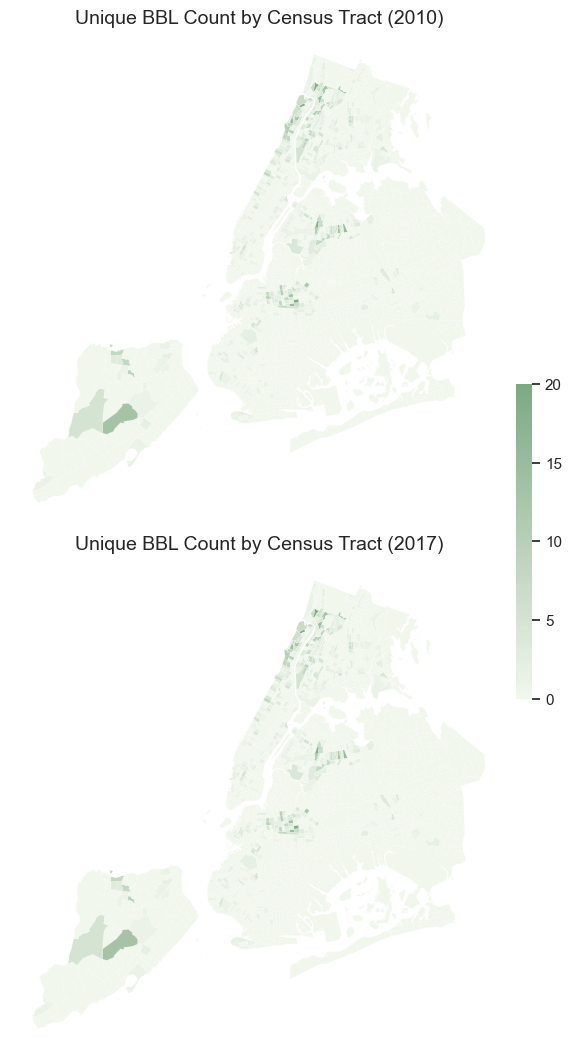

In [79]:

# Aim roughly at US letter size, portrait
fig, axes = plt.subplots(
    2, 1,
    figsize=(8.5, 10.5),          # page-like proportions
    constrained_layout=True
)

for gdf, ax, title in [
    (ct2010_bldg_2010, axes[0], "Unique BBL Count by Census Tract (2010)"),
    (ct2010_bldg_2017, axes[1], "Unique BBL Count by Census Tract (2017)"),
]:
    gdf.plot(
        column="bbl_count",
        ax=ax,
        cmap=bldg_cmap,
        linewidth=0.1,
        edgecolor="white",
        legend=False,
        vmin=0,
        vmax=20,
    )
    ax.set_title(title, fontsize=14, pad=6)
    ax.set_axis_off()

# --- minimalist colorbar, kept slim ---
norm = Normalize(vmin=0, vmax=20)
sm = plt.cm.ScalarMappable(norm=norm, cmap=bldg_cmap)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axes,
    location="right",
    fraction=0.02,        # smaller fraction = slimmer bar
    pad=0.01,
    ticks=np.arange(0, 21, 5),
    format="%d",
)

cbar.outline.set_visible(False)
plt.savefig("fig_2_bbl_maps.png", dpi=300, bbox_inches="tight")

plt.show()


In [84]:
canopy_palette = {
    "Gain":      "#7CA982",  # muted teal
    "Loss":      "#C2A83E",  # old gold
    "No Change": "#243E36",  # dark slate grey
}

### The three Cells Below Take aLong to Run (Dont run unless needed)

In [96]:
# Path to your geodatabase (.gdb)
# https://github.com/CityOfNewYork/nyc-geo-metadata/blob/main/Metadata/Metadata_TreeCanopyChange.md
gdb_path = r"C:\Users\johnf\Downloads\Tree_Canopy_Change (1)\Tree_Canopy_Change\NYC_TreeCanopyChange_2010_2017.gdb"

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)
print("Layers available:", layers)

# Read a specific layer into a GeoDataFrame
gdf = gpd.read_file(gdb_path, layer=layers[0])  # Replace [0] with your desired layer
print(gdf.head())

# Optional: save as shapefile or GeoJSON
# gdf.to_file("output.shp") 
# gdf.to_file("output.geojson", driver="GeoJSON")

canopy_change = gdf.copy()
# canopy_change
print(canopy_change.crs)
ct2010=gdf.copy()

Layers available: ['NYC_TreeCanopyChange_2010_2017']
       Class  Shape_Length    Shape_Area  \
0  No Change    732.955182   5800.500001   
1  No Change   2079.456465  35005.875002   
2  No Change    228.557599   1984.500000   
3  No Change    125.726893    617.750000   
4  No Change     41.031601     90.750000   

                                            geometry  
0  MULTIPOLYGON (((1008879.93 272372.3, 1008878.4...  
1  MULTIPOLYGON (((1008749.43 271870.8, 1008748.9...  
2  MULTIPOLYGON (((1008704.43 272105.3, 1008701.9...  
3  MULTIPOLYGON (((1009015.43 272757.3, 1009013.4...  
4  MULTIPOLYGON (((1008794.93 270669.8, 1008781.4...  
EPSG:2263


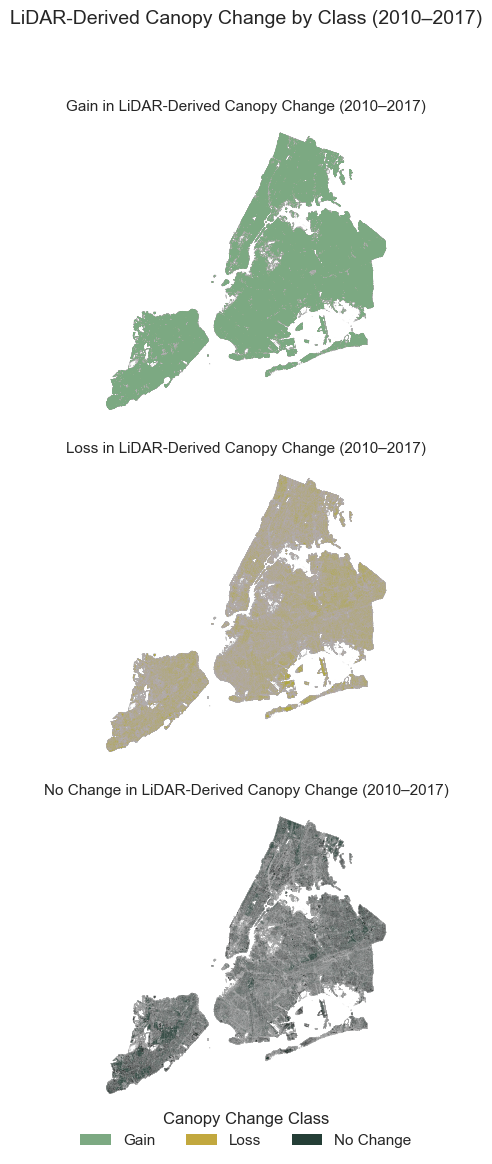

In [97]:
classes = ["Gain", "Loss", "No Change"]

# 3 rows, 1 column (stacked vertically)
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(8, 12),   # tuned for an 8.5x11 Word page
    sharex=True,
    sharey=True
)

# Make sure axes is always iterable
axes = axes.ravel()

for ax, cls in zip(axes, classes):
    # Background
    ax.set_facecolor("#F1F7ED")

    # 1. Base layer – tracts in light grey
    ct2010.boundary.plot(
        ax=ax,
        linewidth=0.3,
        edgecolor="#B0B0B0",
        zorder=1
    )

    # 2. Canopy polygons for this class only
    subset = canopy_change[canopy_change["Class"] == cls]
    subset.plot(
        ax=ax,
        color=canopy_palette[cls],
        edgecolor="none",
        alpha=0.85,
        linewidth=0,
        zorder=2
    )

    # 3. Per-panel title
    ax.set_title(f"{cls} in LiDAR-Derived Canopy Change (2010–2017)",
                 fontsize=11, pad=6)
    ax.set_axis_off()

# Overall figure title
fig.suptitle("LiDAR-Derived Canopy Change by Class (2010–2017)",
             fontsize=14, y=0.98)
# Shared legend for all three panels
handles = [
    Patch(facecolor=color, edgecolor="none", label=cls)
    for cls, color in canopy_palette.items()
]
fig.legend(
    handles=handles,
    title="Canopy Change Class",
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=(0, 0.05, 1, 0.95))
plt.savefig("fig_3_can_map_by_class.png", dpi=300, bbox_inches="tight")
plt.show()

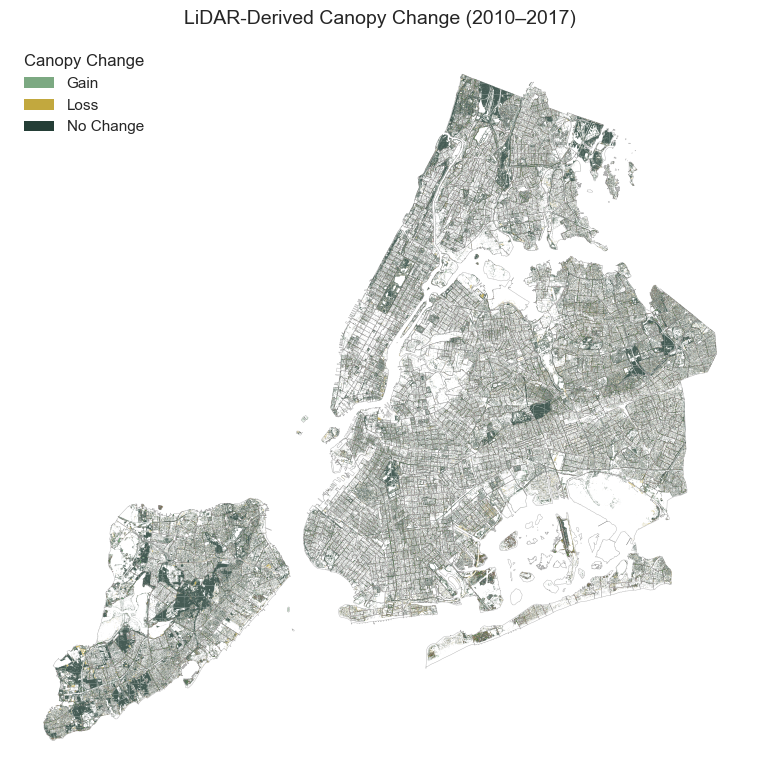

In [426]:

fig, ax = plt.subplots(figsize=(12, 8))

# Optional: slightly off-white background so grey lines are visible
ax.set_facecolor("#F1F7ED")

# 1. Base layer – tracts / city boundary in light grey
ct2010.boundary.plot(
    ax=ax,
    linewidth=0.3,
    edgecolor="#B0B0B0",  # darker than before so it’s visible
    zorder=1
)

# 2. Canopy change polygons – higher contrast colors
canopy_palette = {
    "Gain":      "#7CA982",  # muted teal
    "Loss":      "#C2A83E",  # old gold
    "No Change": "#243E36",  # dark slate grey
}

for cls, color in canopy_palette.items():
    canopy_change[canopy_change["Class"] == cls].plot(
        ax=ax,
        color=color,
        edgecolor="none",
        alpha=0.85,      # much more opaque
        linewidth=0,
        zorder=2
    )

# 3. Title / axes
ax.set_title("LiDAR-Derived Canopy Change (2010–2017)", fontsize=14, pad=12)
ax.set_axis_off()

# 4. Legend using proxy patches (no warnings, clean look)
handles = [
    Patch(facecolor=color, edgecolor="none", label=cls)
    for cls, color in canopy_palette.items()
]
ax.legend(
    handles=handles,
    title="Canopy Change",
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.savefig("fig_3_can_map.png", dpi=300, bbox_inches="tight")
plt.show()


### BUILDING FOCUSED PLOTS

C:\Users\johnf\AppData\Local\Temp\ipykernel_67620\378691014.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


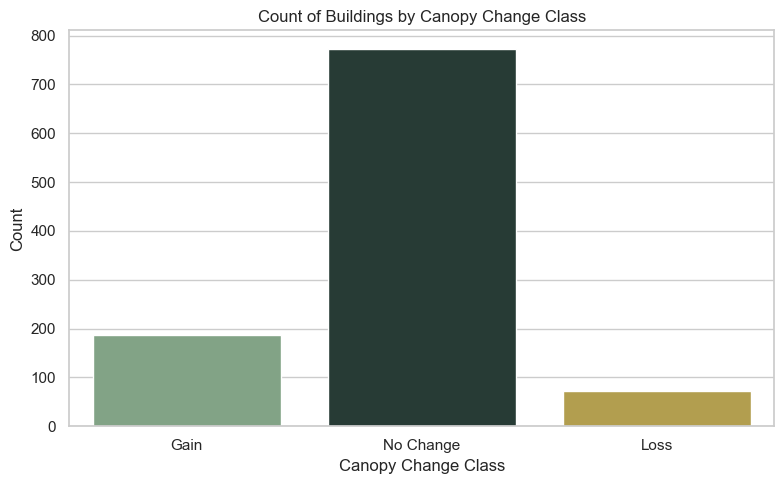

In [46]:
df = building_trees_all_lim_trees4.copy()

# Count of canopy_change_class
fig, ax = plt.subplots()
order = ["Gain", "No Change", "Loss"]
sns.countplot(
    data=df,
    x="canopy_change_class",
    order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Count of Buildings by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Count")
plt.tight_layout()

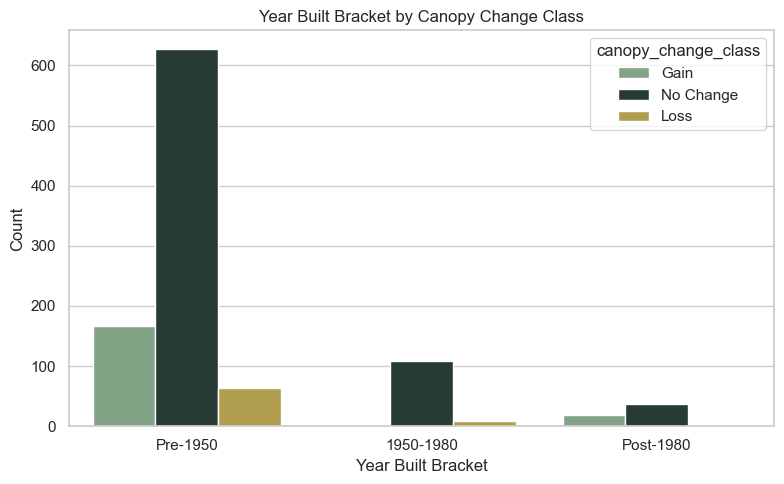

In [47]:
fig, ax = plt.subplots()
sns.countplot(
    data=df,
    x="year_built_bracket",
    hue="canopy_change_class",
    hue_order=order,
    palette=[canopy_palette[o] for o in order],
    ax=ax
)
ax.set_title("Year Built Bracket by Canopy Change Class")
ax.set_xlabel("Year Built Bracket")
ax.set_ylabel("Count")
# plt.xticks(rotation=45)
plt.tight_layout()


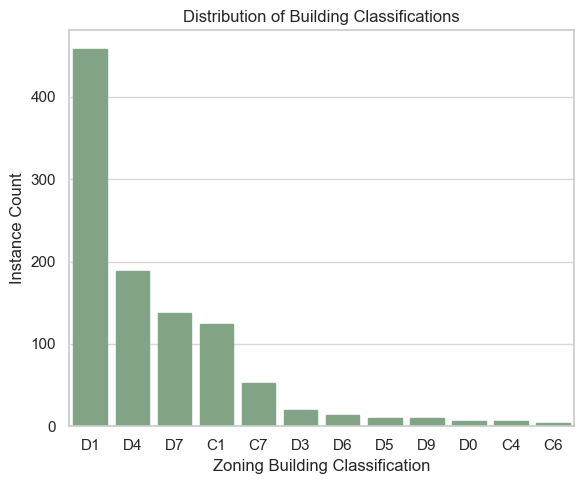

In [48]:
# Get counts of each BldgClass, sorted descending
bldg_counts = (
    building_trees_all_lim_trees4["BldgClass"]
    .value_counts()
    .sort_values(ascending=False)
)
order = bldg_counts.index  # sorted from most to least frequent

plt.figure(figsize=(6, 5))
sns.countplot(
    data=building_trees_all_lim_trees4,
    x="BldgClass",
    order=order,
    color=colors["muted_teal"],  # or colors["dark_gray"]
    edgecolor=colors["muted_teal"]
)

plt.xlabel("Zoning Building Classification")
plt.ylabel("Instance Count")
plt.title("Distribution of Building Classifications")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()


In [89]:
building_trees_all_lim_trees4.columns

Index(['year', 'ct2010', 'bbl', 'year_built', 'BldgClass', 'NumFloors',
       'canopy_change_class', 'UnitsRes', 'ground_elevation', 'height_roof',
       'weather_normalized_site_eui', 'tree_count', 'commercial_floor_flag',
       'year_built_bracket'],
      dtype='object')

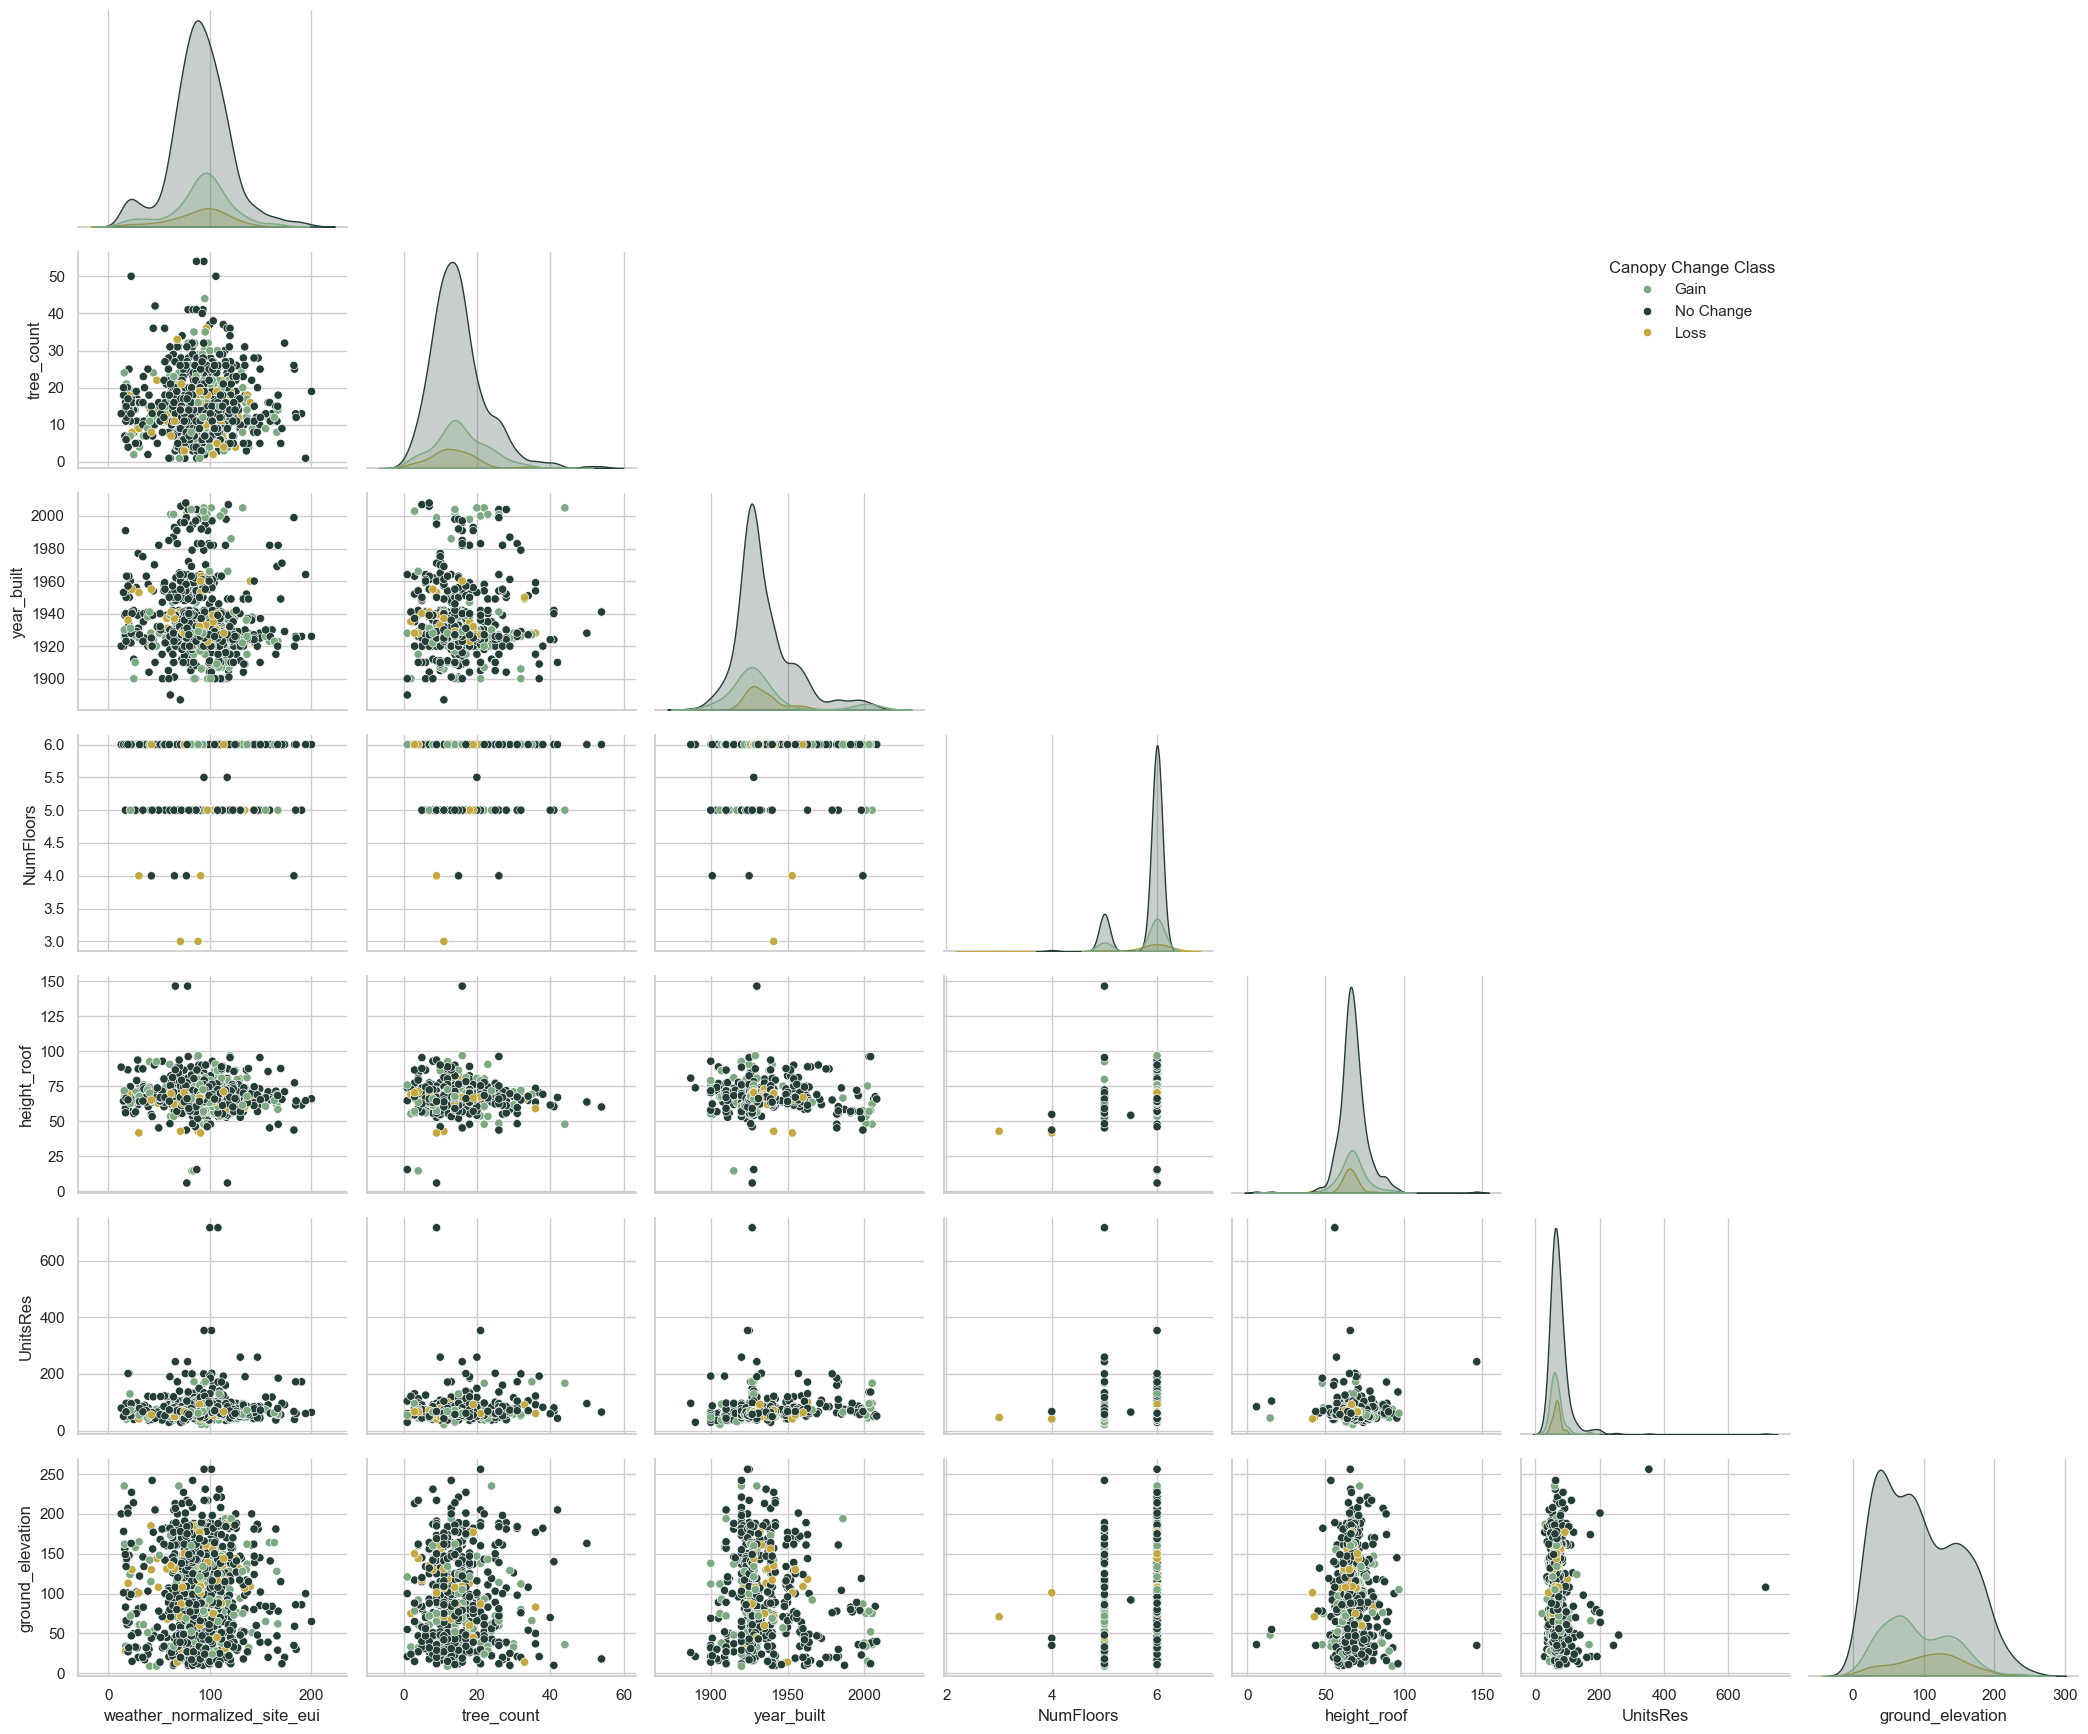

In [52]:
pair_cols = ["weather_normalized_site_eui",
             "tree_count",
             "year_built",
             "NumFloors",
             "height_roof",
             'UnitsRes', 
             'ground_elevation',
             # 'commercial_floor_flag'
]
g = sns.pairplot(
    data=building_trees_all_lim_trees4,
    vars=pair_cols,
    hue="canopy_change_class",
    # hue_order=order,
    palette=canopy_palette,
    corner=True,
    diag_kind="kde"
)

# Remove the automatically created legend
if g._legend is not None:
    g._legend.remove()

# Add a new legend in the upper-right corner of the figure
g.add_legend(
    title="Canopy Change Class",
    bbox_to_anchor=(0.85, 0.85),  # (x, y) in figure coords
    loc="upper right",            # position relative to that anchor
    borderaxespad=0
)

g.fig.tight_layout()
g.fig.savefig("fig_4_pairplot_2.png", dpi=300, bbox_inches="tight")


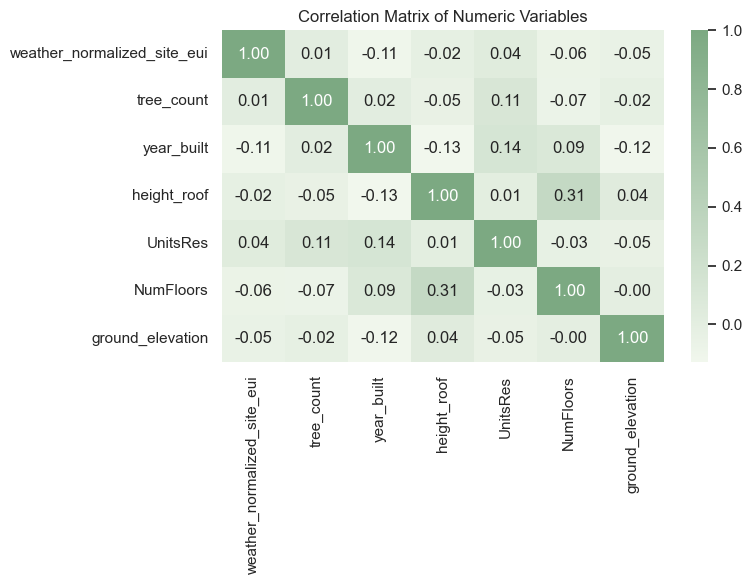

In [53]:
corr_cols = [
    "weather_normalized_site_eui",
    "tree_count",
    'year_built',
    "height_roof",
    "UnitsRes",
    "NumFloors",
    "ground_elevation"
]

corr = df[corr_cols].corr()

corr_cmap = LinearSegmentedColormap.from_list(
    "corr_cmap",
    [colors["mint_cream"],colors["muted_teal"]]
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=corr_cmap,
    ax=ax
)
ax.set_title("Correlation Matrix of Numeric Variables")
plt.tight_layout()


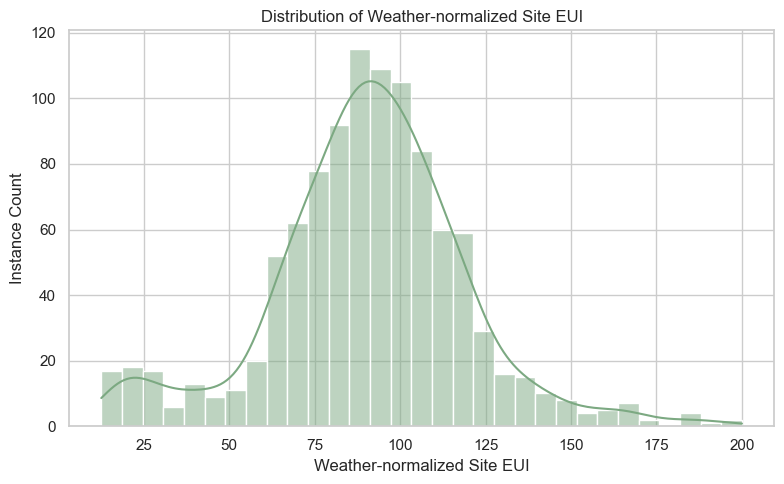

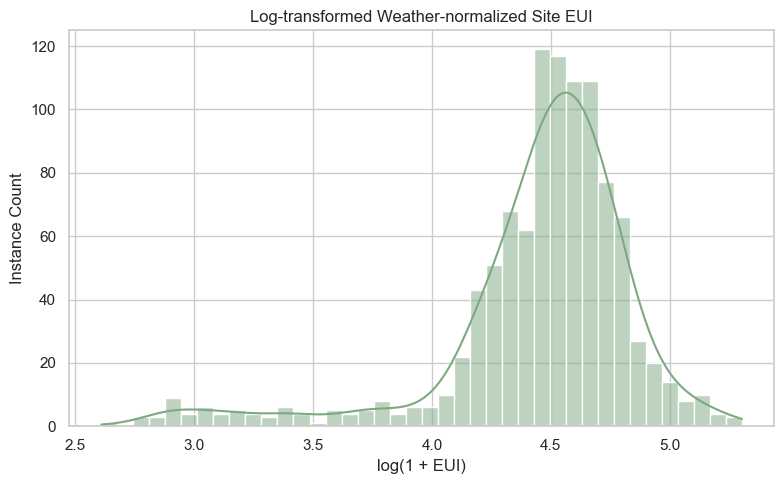

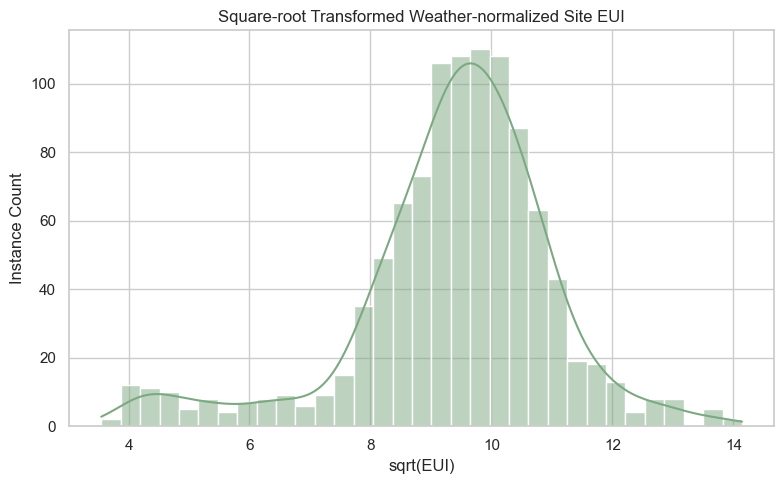

In [54]:
# Raw EUI
fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="weather_normalized_site_eui",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Distribution of Weather-normalized Site EUI")
ax.set_xlabel("Weather-normalized Site EUI")
ax.set_ylabel("Instance Count")
plt.tight_layout()

# Log-transformed
building_trees_all_lim_trees4["log_eui"] = np.log1p(
    building_trees_all_lim_trees4["weather_normalized_site_eui"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="log_eui",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Log-transformed Weather-normalized Site EUI")
ax.set_xlabel("log(1 + EUI)")
ax.set_ylabel("Instance Count")
plt.tight_layout()

# Square-root transformed
building_trees_all_lim_trees4["sqrt_eui"] = np.sqrt(
    building_trees_all_lim_trees4["weather_normalized_site_eui"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="sqrt_eui",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Square-root Transformed Weather-normalized Site EUI")
ax.set_xlabel("sqrt(EUI)")
ax.set_ylabel("Instance Count")
plt.tight_layout()


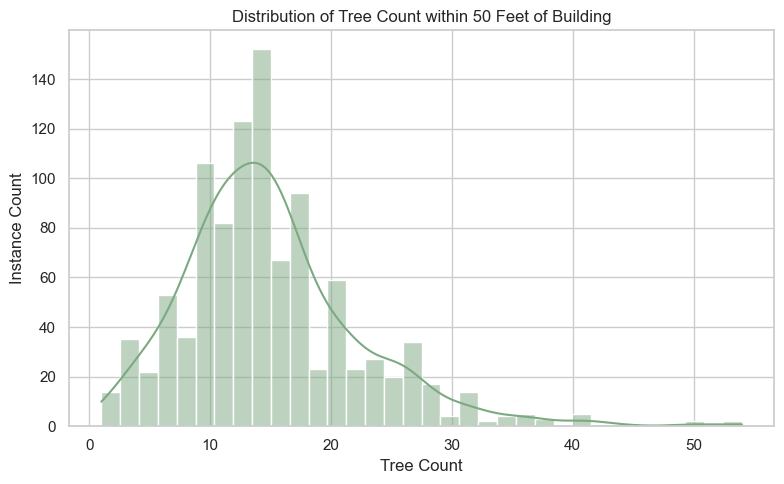

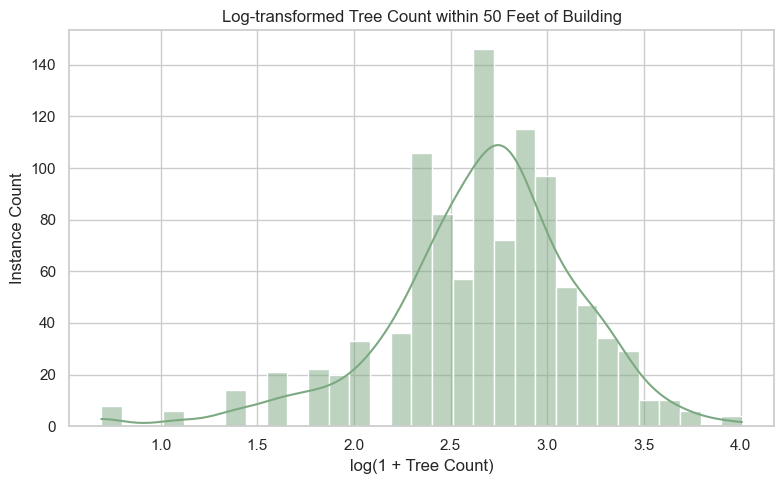

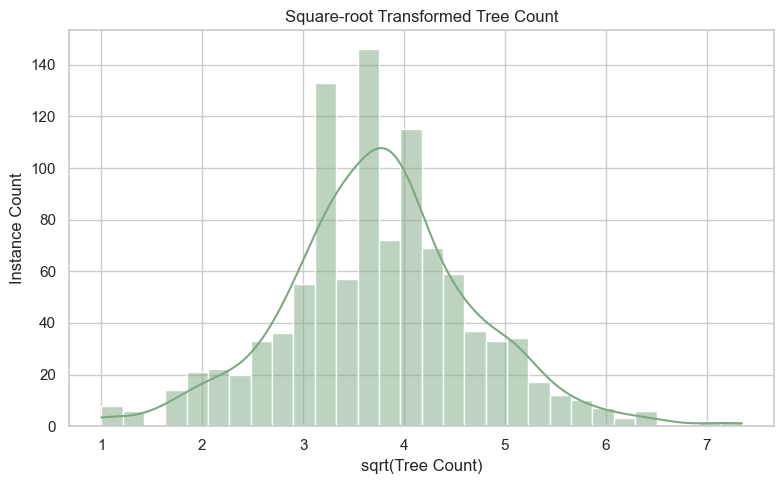

In [55]:
fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="tree_count",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Distribution of Tree Count within 50 Feet of Building")
ax.set_ylabel("Instance Count")
ax.set_xlabel("Tree Count")
plt.tight_layout()

# Log-transformed
building_trees_all_lim_trees4["log_tree_count"] = np.log1p(
    building_trees_all_lim_trees4["tree_count"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="log_tree_count",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Log-transformed Tree Count within 50 Feet of Building")
ax.set_ylabel("Instance Count")
ax.set_xlabel("log(1 + Tree Count)")
plt.tight_layout()

# Square-root transformed
building_trees_all_lim_trees4["sqrt_tree_count"] = np.sqrt(
    building_trees_all_lim_trees4["tree_count"]
)

fig, ax = plt.subplots()
sns.histplot(
    data=building_trees_all_lim_trees4,
    x="sqrt_tree_count",
    kde=True,
    color=colors["muted_teal"],
    ax=ax
)
ax.set_title("Square-root Transformed Tree Count")
ax.set_xlabel("sqrt(Tree Count)")
ax.set_ylabel("Instance Count")
plt.tight_layout()


C:\Users\johnf\AppData\Local\Temp\ipykernel_42640\305820373.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_42640\305820373.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


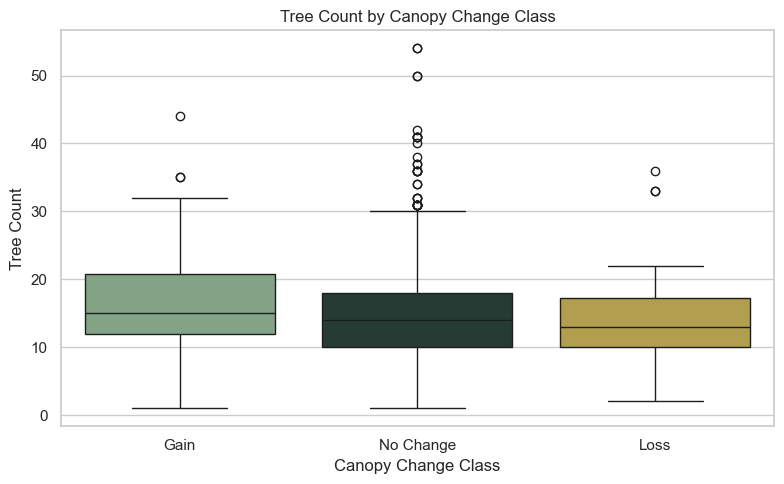

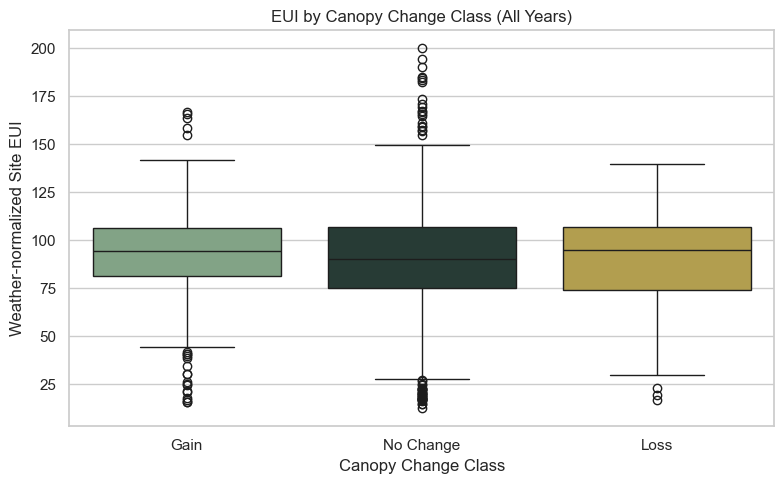

In [98]:
# Tree count by canopy_change_class
fig, ax = plt.subplots()
sns.boxplot(
    data=df,
    x="canopy_change_class",
    y="tree_count",
    # order=order,
    palette=canopy_palette,
    ax=ax
)
ax.set_title("Tree Count by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Tree Count")
plt.tight_layout()

fig, ax = plt.subplots()
sns.boxplot(
    data=df,
    x="canopy_change_class",
    y="weather_normalized_site_eui",
    # order=order,
    palette=canopy_palette,
    ax=ax
)
ax.set_title("EUI by Canopy Change Class (All Years)")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Weather-normalized Site EUI")
plt.tight_layout()

C:\Users\johnf\AppData\Local\Temp\ipykernel_42640\2602456472.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


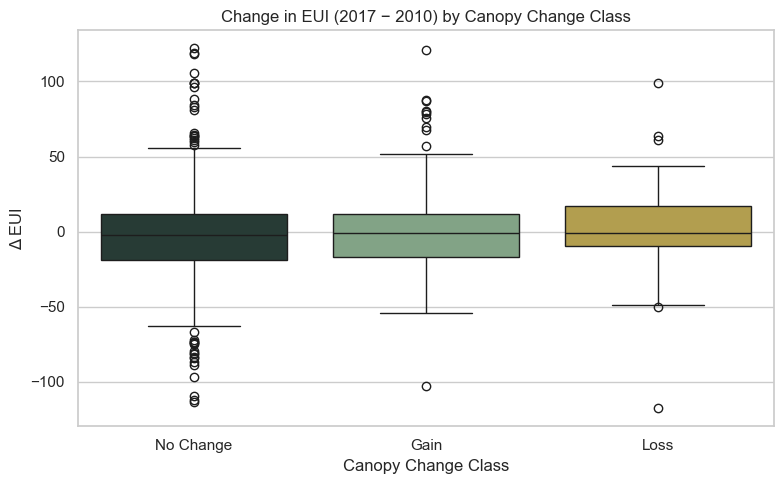

In [99]:
df_panel = df.pivot_table(
    index="bbl",
    columns="year",
    values="weather_normalized_site_eui"
).reset_index()

df_panel["delta_eui"] = df_panel[2017] - df_panel[2010]

df_panel = df_panel.merge(
    df[["bbl", "canopy_change_class"]].drop_duplicates(),
    on="bbl",
    how="left"
)

fig, ax = plt.subplots()
sns.boxplot(
    data=df_panel,
    x="canopy_change_class",
    y="delta_eui",
    # order=order,
    palette=canopy_palette,
    ax=ax
)
ax.set_title("Change in EUI (2017 − 2010) by Canopy Change Class")
ax.set_xlabel("Canopy Change Class")
ax.set_ylabel("Δ EUI")
plt.tight_layout()


### EDA Visuals Not Included In Report 

In [489]:
# fig, ax = plt.subplots()
# sns.boxplot(
#     data=df,
#     x="canopy_change_class",
#     y="weather_normalized_site_eui",
#     hue="year",
#     order=order,
#     palette=[colors["dark_slate_grey"], colors["old_gold"]],
#     ax=ax
# )
# ax.set_title("EUI by Canopy Change Class and Year")
# ax.set_xlabel("Canopy Change Class")
# ax.set_ylabel("Weather-normalized Site EUI")
# plt.tight_layout()


C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\johnf\AppData\Local\Temp\ipykernel_75868\914816135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

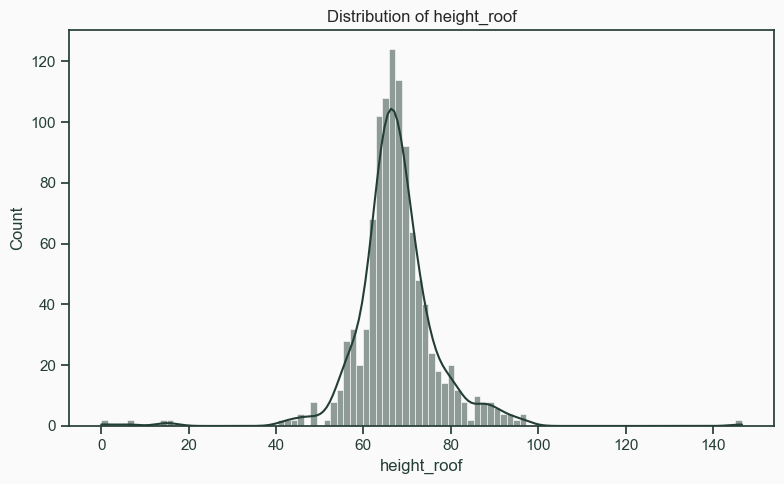

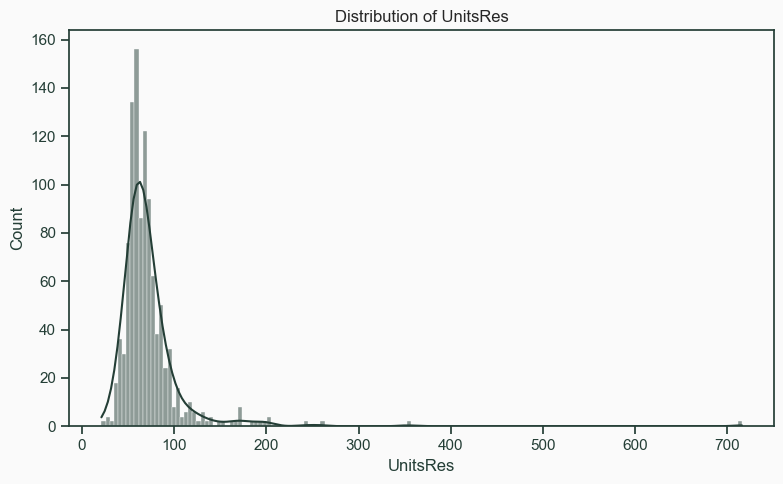

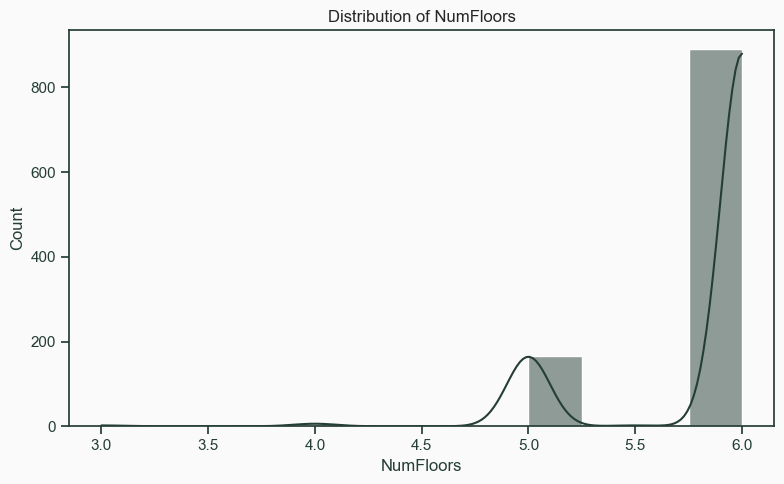

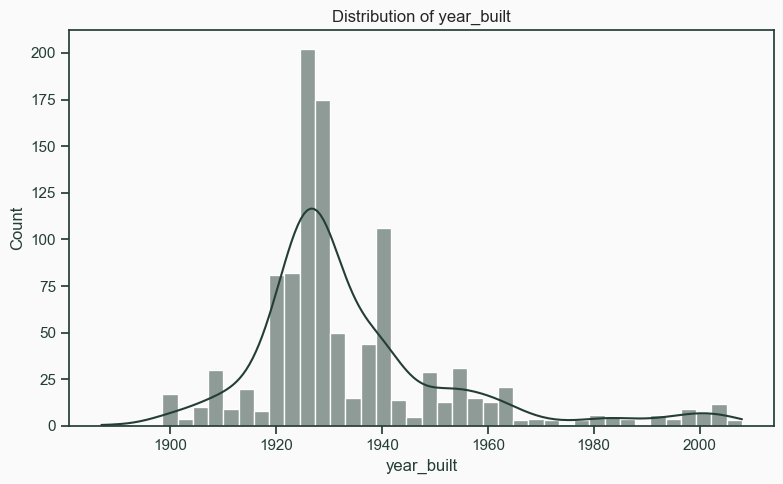

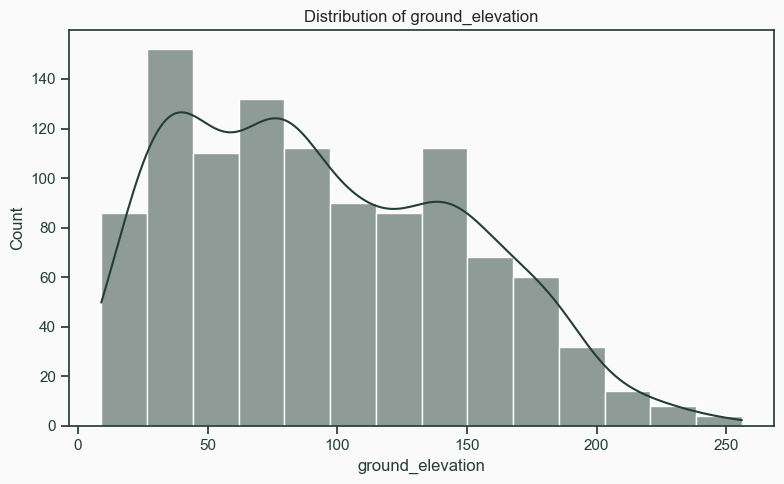

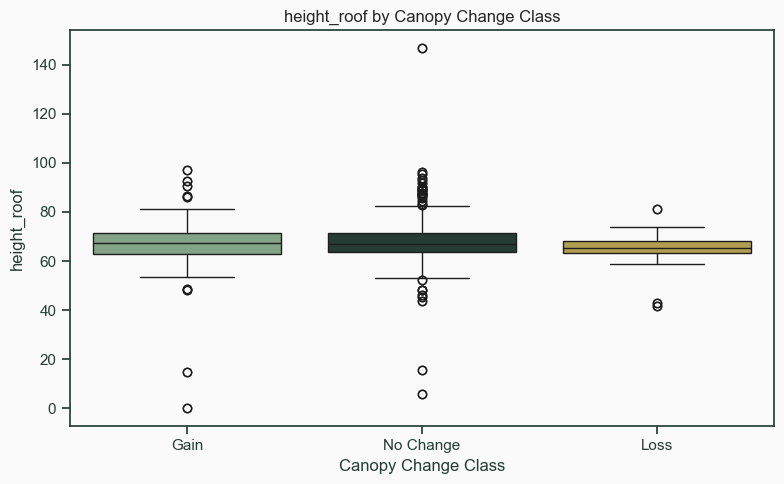

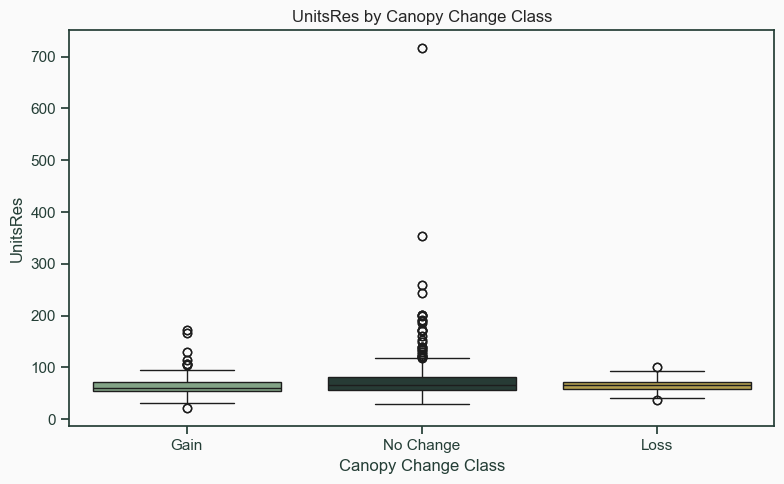

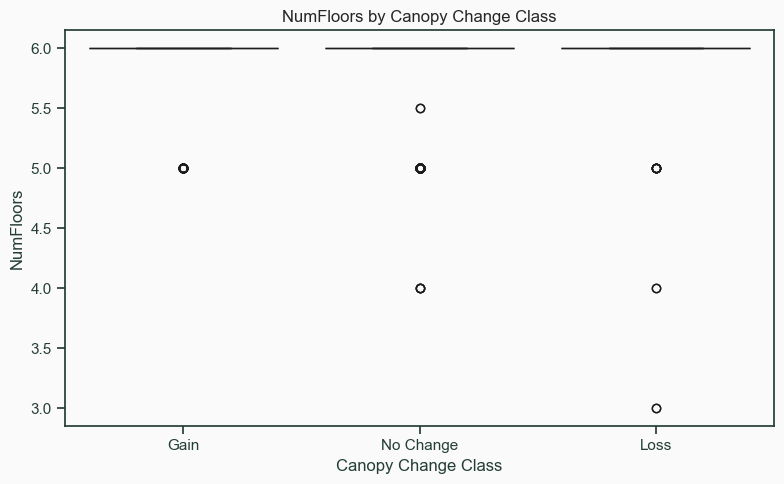

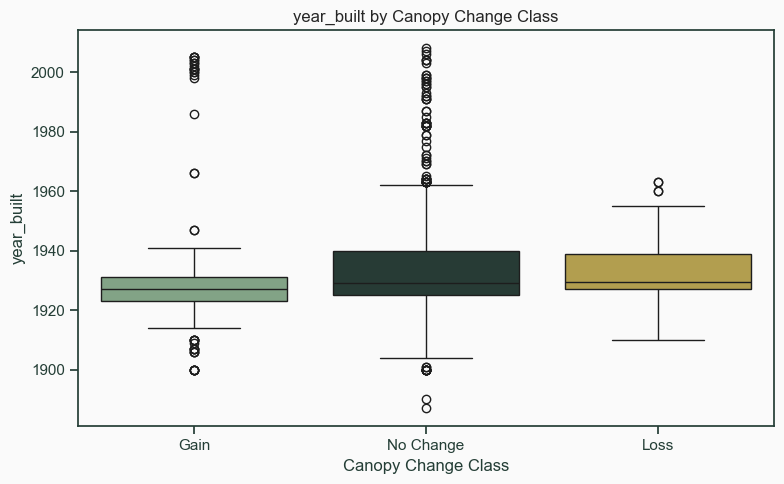

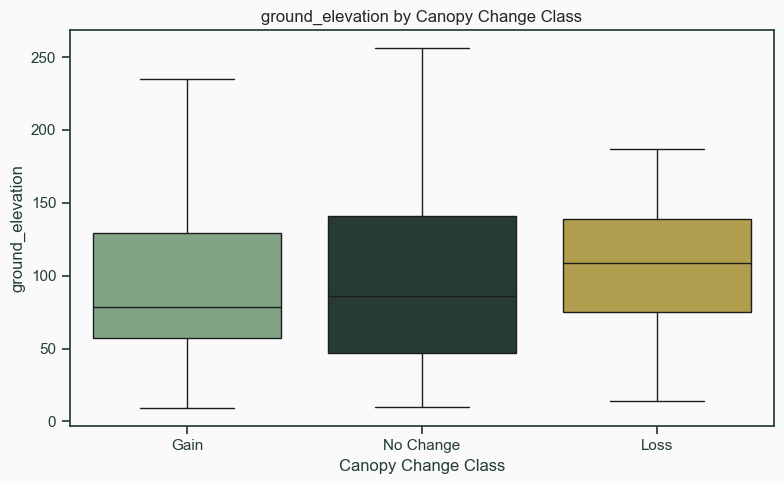

In [444]:
num_cols = ["height_roof", "UnitsRes", "NumFloors", "year_built", "ground_elevation"]

# Overall distributions
for col in num_cols:
    fig, ax = plt.subplots()
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        color=colors["dark_slate_grey"],
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    plt.tight_layout()

# By canopy class
for col in num_cols:
    fig, ax = plt.subplots()
    sns.boxplot(
        data=df,
        x="canopy_change_class",
        y=col,
        order=order,
        palette=[canopy_palette[o] for o in order],
        ax=ax
    )
    ax.set_title(f"{col} by Canopy Change Class")
    ax.set_xlabel("Canopy Change Class")
    ax.set_ylabel(col)
    plt.tight_layout()


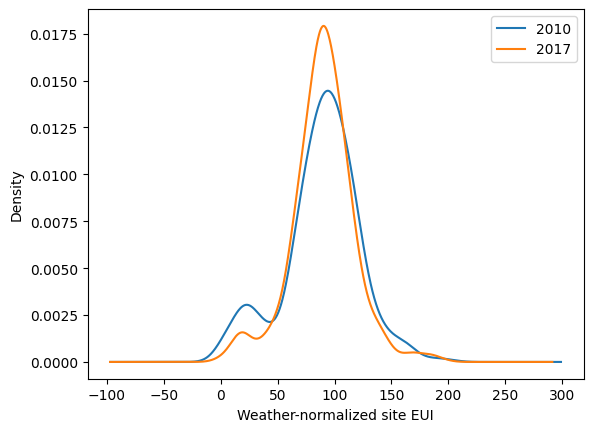

In [274]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for y in [2010, 2017]:
    subset = df[df['year'] == y]['weather_normalized_site_eui']
    subset.plot(kind='kde', ax=ax, label=str(y))
ax.set_xlabel("Weather-normalized site EUI")
ax.legend()
plt.show()


In [495]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# for y in [2010, 2017]:
#     subset = df[df['year'] == y]['tree_count']
#     subset.plot(kind='kde', ax=ax, label=str(y))
# ax.set_xlabel("Count of Trees within 50 ft of Building")
# ax.legend()
# plt.show()


## ------ EDA END

## First Modeling Section - Difference in Difference Model Technique Using the Canopy Change Data 

In [57]:
df = building_trees_all_lim_trees4.copy()
## Making this a binary value
df['post_2017'] = (df['year'] == 2017).astype(int)
## Ensuring that the "No Change" Category is the baseline wit the gain/ loss being the changes. 
cat_type = pd.api.types.CategoricalDtype(categories=['No Change', 'Gain', 'Loss'], ordered=False)
## Aplying to DF
df['canopy_change_class'] = df['canopy_change_class'].astype(cat_type)

In [58]:
df.head()

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,commercial_floor_flag,year_built_bracket,log_eui,sqrt_eui,log_tree_count,sqrt_tree_count,post_2017
15,2010,1900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,1,Pre-1950,3.730501,6.379655,2.564949,3.464102,0
16,2010,2201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,0,Post-1980,4.229749,8.228001,3.465736,5.567764,0
17,2010,2500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,0,1950-1980,4.378270,8.871302,2.397895,3.162278,0
22,2010,3001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,0,Pre-1950,3.258097,5.000000,1.098612,1.414214,0
23,2010,3100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,1,Pre-1950,4.709530,10.488088,2.890372,4.123106,0


### MODEL 1 - DID (ALL CONTROLS, NO TRANSFORM)

In [59]:
# Base DiD formula – EUI level
formula = """
weather_normalized_site_eui
    ~ post_2017 * canopy_change_class
    + NumFloors
    + UnitsRes
    + ground_elevation
    + height_roof
    + C(year_built_bracket)
    +C(commercial_floor_flag)
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                                 OLS Regression Results                                
Dep. Variable:     weather_normalized_site_eui   R-squared:                       0.037
Model:                                     OLS   Adj. R-squared:                  0.026
Method:                          Least Squares   F-statistic:                     2.439
Date:                         Sun, 07 Dec 2025   Prob (F-statistic):            0.00431
Time:                                 12:09:23   Log-Likelihood:                -4902.4
No. Observations:                         1030   AIC:                             9831.
Df Residuals:                             1017   BIC:                             9895.
Df Model:                                   12                                         
Covariance Type:                       cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------

### MODEL 2 - DID (ALL CONTROLS, LOG TRANSFORM)

In [60]:
log_formula = formula.replace('weather_normalized_site_eui', 'log_eui')

did_model_log = smf.ols(formula=log_formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}
)
print(did_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                log_eui   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.090
Date:                Sun, 07 Dec 2025   Prob (F-statistic):             0.0162
Time:                        12:09:48   Log-Likelihood:                -519.69
No. Observations:                1030   AIC:                             1065.
Df Residuals:                    1017   BIC:                             1130.
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### MODEL 3 - DID (All CONTROLS, Sq Root TRANSFORM)

In [62]:
sqrt_formula = formula.replace('weather_normalized_site_eui','sqrt_eui')

did_model_log = smf.ols(formula=sqrt_formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}
)
print(did_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               sqrt_eui   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.335
Date:                Sun, 07 Dec 2025   Prob (F-statistic):            0.00645
Time:                        12:14:46   Log-Likelihood:                -1958.9
No. Observations:                1030   AIC:                             3944.
Df Residuals:                    1017   BIC:                             4008.
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### NOTE: Multicolinearity warning so attmping to limit the input features via formula  ( only Keeping Number of Floors and year built bracket)

### MODEL 4 - DID (Limited CONTROLS, No TRANSFORM)

In [63]:
# Base DiD formula – EUI level
formula = """
weather_normalized_site_eui
    ~ post_2017 * canopy_change_class
    + NumFloors
    + C(year_built_bracket)
    + C(commercial_floor_flag)
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                                 OLS Regression Results                                
Dep. Variable:     weather_normalized_site_eui   R-squared:                       0.032
Model:                                     OLS   Adj. R-squared:                  0.024
Method:                          Least Squares   F-statistic:                     2.658
Date:                         Sun, 07 Dec 2025   Prob (F-statistic):            0.00509
Time:                                 12:18:36   Log-Likelihood:                -4905.2
No. Observations:                         1030   AIC:                             9830.
Df Residuals:                             1020   BIC:                             9880.
Df Model:                                    9                                         
Covariance Type:                       cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------

### MODEL 5 - DID (Limited CONTROLS, Log TRANSFORM)

In [64]:
formula = """
log_eui
    ~ post_2017 * canopy_change_class
        + NumFloors
    + C(year_built_bracket)
    + C(commercial_floor_flag)
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:                log_eui   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.122
Date:                Sun, 07 Dec 2025   Prob (F-statistic):             0.0262
Time:                        12:20:00   Log-Likelihood:                -522.50
No. Observations:                1030   AIC:                             1065.
Df Residuals:                    1020   BIC:                             1114.
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### MODEL 6 - Sq Root Transformed Limited Control Features 

In [65]:
formula = """
sqrt_eui
    ~ post_2017 * canopy_change_class
        + NumFloors
    + C(year_built_bracket)
    + C(commercial_floor_flag)
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:               sqrt_eui   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.449
Date:                Sun, 07 Dec 2025   Prob (F-statistic):            0.00978
Time:                        12:26:59   Log-Likelihood:                -1961.7
No. Observations:                1030   AIC:                             3943.
Df Residuals:                    1020   BIC:                             3993.
Df Model:                           9                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### MODEL 7 - Non-Transformed Controlling for No Features 

In [110]:
formula = """
weather_normalized_site_eui
    ~ post_2017 * canopy_change_class
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                                 OLS Regression Results                                
Dep. Variable:     weather_normalized_site_eui   R-squared:                       0.001
Model:                                     OLS   Adj. R-squared:                 -0.003
Method:                          Least Squares   F-statistic:                    0.4113
Date:                         Sat, 06 Dec 2025   Prob (F-statistic):              0.841
Time:                                 13:26:40   Log-Likelihood:                -4921.2
No. Observations:                         1030   AIC:                             9854.
Df Residuals:                             1024   BIC:                             9884.
Df Model:                                    5                                         
Covariance Type:                       cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------

### MODEL 8 - Log Transformed Controlling for No Features 

In [66]:
formula = """
log_eui
    ~ post_2017 * canopy_change_class
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:                log_eui   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4514
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.812
Time:                        12:36:00   Log-Likelihood:                -537.26
No. Observations:                1030   AIC:                             1087.
Df Residuals:                    1024   BIC:                             1116.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### MODEL 9 - Sq Root Transformed Controlling for No Features 

In [67]:
formula = """
sqrt_eui
    ~ post_2017 * canopy_change_class
"""

did_model = smf.ols(formula=formula, data=df).fit(
    cov_type='cluster',
    cov_kwds={'groups': df['bbl']}  # cluster by building
)

print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:               sqrt_eui   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3788
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.863
Time:                        12:38:55   Log-Likelihood:                -1977.7
No. Observations:                1030   AIC:                             3967.
Df Residuals:                    1024   BIC:                             3997.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## Second Modeling Section - Predictive Modeling with Ridge / Lasso Techniques

In [69]:
df2 = building_trees_all_lim_trees4.copy()
## Restructuring for Predictive Regression MOdel 
df2 = df2[['year', 'bbl', 'year_built', 'BldgClass', 'NumFloors','canopy_change_class', 'UnitsRes', 'ground_elevation', 'height_roof',
       'weather_normalized_site_eui', 'tree_count', 'commercial_floor_flag','year_built_bracket']]
df2_2010 = df2[df2['year']==2010]
df2_2017 = df2[df2['year']==2017]
df2_2010 = df2_2010.rename(columns={"tree_count":"tree_count_2010","weather_normalized_site_eui":"weather_normalized_site_eui_2010"})
df2_2017 = df2_2017.rename(columns={"tree_count":"tree_count_2017","weather_normalized_site_eui":"weather_normalized_site_eui_2017"})

## Keeping 2010 building info. 
joined = df2_2010.merge(df2_2017[['bbl', 'weather_normalized_site_eui_2017', 'tree_count_2017']],on='bbl',how='inner')
joined.head()

,year,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui_2010,tree_count_2010,commercial_floor_flag,year_built_bracket,weather_normalized_site_eui_2017,tree_count_2017
0,2010,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,1,Pre-1950,47.3,12
1,2010,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,0,Post-1980,67.9,31
2,2010,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,0,1950-1980,79.0,10
3,2010,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,0,Pre-1950,103.4,2
4,2010,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,1,Pre-1950,100.0,17


In [70]:
## Creating delta cols 
joined['delta_eui'] = joined['weather_normalized_site_eui_2017'] - joined['weather_normalized_site_eui_2010']
joined['delta_tree_count'] = joined['tree_count_2017'] - joined['tree_count_2010']

numeric_features = ['tree_count_2010', 'tree_count_2017', 'delta_tree_count','NumFloors', 'UnitsRes', 'height_roof', 'ground_elevation']
categorical_features = ['canopy_change_class', 'year_built_bracket', 'BldgClass']

X = joined[numeric_features + categorical_features]
y = joined["delta_eui"]

## 80 - 20 Split for training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(drop='first',handle_unknown='ignore')
preprocess = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                             ('cat', categorical_transformer, categorical_features)])
ols_model = Pipeline(steps=[('preprocess', preprocess),('regressor', LinearRegression())])
ols_model.fit(X_train, y_train)

## Results of simple OLS Model 
y_pred_test_ols = ols_model.predict(X_test)
mse_test_ols  = mean_squared_error(y_test, y_pred_test_ols)
rmse_test_ols = np.sqrt(mse_test_ols)
mae_test_ols  = mean_absolute_error(y_test, y_pred_test_ols)
r2_test_ols   = r2_score(y_test, y_pred_test_ols)

print(f"OLS MSE : {mse_test_ols:.3f}")
print(f"OLS RMSE: {rmse_test_ols:.3f}")
print(f"OLS MAE : {mae_test_ols:.3f}")
print(f"OLS R^2 : {r2_test_ols:.4f}")

OLS MSE : 1230.177
OLS RMSE: 35.074
OLS MAE : 24.516
OLS R^2 : -0.2282


In [92]:
### MOving over to Ridge Regression With CV; Multicolinarity and want to keep for now 
### array for the ridge weights
alpha_vals= np.logspace(-3, 3, 100)  # from 0.001 to 1000
ridge_cv = RidgeCV(alphas=alpha_vals, cv=5, scoring='neg_mean_squared_error') 
ridge_model = Pipeline(steps=[('preprocess', preprocess),('regressor', ridge_cv)])
ridge_model.fit(X_train, y_train)
print("Chosen alpha (ridge):", ridge_cv.alpha_) ## 483.29 is best 
y_pred_test_ridge = ridge_model.predict(X_test)
mse_test_ridge  = mean_squared_error(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
mae_test_ridge  = mean_absolute_error(y_test, y_pred_test_ridge)
r2_test_ridge   = r2_score(y_test, y_pred_test_ridge)
print(f"Ridge  MSE : {mse_test_ridge:.3f}")
print(f"Ridge  RMSE: {rmse_test_ridge:.3f}")
print(f"Ridge  MAE : {mae_test_ridge:.3f}")
print(f"Ridge  R^2 : {r2_test_ridge:.4f}")

Chosen alpha (ridge): 572.236765935022
Ridge  MSE : 1032.155
Ridge  RMSE: 32.127
Ridge  MAE : 22.089
Ridge  R^2 : -0.0305


###### Trying Lasso 

In [93]:
## See what lasso does if coeficients can go to zero
lasso_cv = LassoCV(alphas=alpha_vals, cv=5,random_state=42)
lasso_model = Pipeline(steps=[('preprocess', preprocess),('regressor', lasso_cv)])
lasso_model.fit(X_train, y_train)
print("Chosen alpha (lasso):", lasso_cv.alpha_)
y_pred_test_lasso = lasso_model.predict(X_test)
mse_test_lasso  = mean_squared_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mae_test_lasso  = mean_absolute_error(y_test, y_pred_test_lasso)
r2_test_lasso   = r2_score(y_test, y_pred_test_lasso)
print(f"Lasso MSE : {mse_test_lasso:.3f}")
print(f"Lasso RMSE: {rmse_test_lasso:.3f}")
print(f"Lasso MAE : {mae_test_lasso:.3f}")
print(f"Lasso R^2 : {r2_test_lasso:.4f}")

Chosen alpha (lasso): 1.072267222010323
Lasso MSE : 1035.806
Lasso RMSE: 32.184
Lasso MAE : 22.087
Lasso R^2 : -0.0341


In [346]:
building_trees_all_lim_trees4

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,year_built_bracket,commercial_floor_flag
15,2010,001900,2023090001,1920,D7,5.0,Gain,75.0,9.0,92.680000,40.7,12,Pre-1950,1
16,2010,002201,1003450048,1983,D3,6.0,No Change,172.0,21.0,55.770000,67.7,31,Post-1980,0
17,2010,002500,2022810021,1972,D1,6.0,No Change,107.0,44.0,62.050000,78.7,10,1950-1980,0
22,2010,003001,1004110045,1900,D1,6.0,Gain,52.0,33.0,55.430000,25.0,2,Pre-1950,0
23,2010,003100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,Pre-1950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2017,043100,2033560126,1928,D1,6.0,Loss,66.0,150.0,70.520000,74.7,3,Pre-1950,0
2529,2017,043100,2033560180,1929,D1,6.0,Gain,61.0,105.0,96.980000,88.5,16,Pre-1950,0
2530,2017,043400,2050440030,1931,D1,6.0,No Change,61.0,175.0,66.310000,77.5,17,Pre-1950,0
2532,2017,045102,2033880001,1927,C7,5.0,No Change,57.0,149.0,59.260000,79.2,14,Pre-1950,1


In [347]:
#### TESTIN 

bld_2010 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2010]
bld_2017 = building_trees_all_lim_trees4[building_trees_all_lim_trees4['year']==2017]

# test = bld_2010[['bbl','UnitsRes']].merge(bld_2017[['bbl','UnitsRes']], on=['bbl'])
# test[test['UnitsRes_y']!=test['UnitsRes_x']]

test = bld_2010[['bbl','height_roof']].merge(bld_2017[['bbl','height_roof']], on=['bbl'])
test[test['height_roof_y']!=test['height_roof_x']]

,bbl,height_roof_x,height_roof_y


In [355]:
test = bld_2010[['bbl','weather_normalized_site_eui']].rename(columns={"weather_normalized_site_eui":"weather_normalized_site_eui_2010"}
                                                             ).merge(bld_2017[['bbl','weather_normalized_site_eui']].rename(columns={"weather_normalized_site_eui":"weather_normalized_site_eui_2017"}),
                                                                     on=['bbl'])
test['delta_eui'] = test["weather_normalized_site_eui_2017"]-test["weather_normalized_site_eui_2010"]
bbl_decreased = test['bbl'][test['delta_eui']<0].unique()

decreased_eui = building_trees_all_lim_trees4[building_trees_all_lim_trees4['bbl'].isin(bbl_decreased)]


In [356]:
decreased_eui[["year_built",]]

,year,ct2010,bbl,year_built,BldgClass,NumFloors,canopy_change_class,UnitsRes,ground_elevation,height_roof,weather_normalized_site_eui,tree_count,year_built_bracket,commercial_floor_flag
23,2010,003100,2025820034,1925,C7,6.0,Loss,77.0,34.0,63.292863,110.0,17,Pre-1950,1
24,2010,003500,2025770038,1928,D7,6.0,No Change,65.0,36.0,64.960000,93.2,13,Pre-1950,1
32,2010,003900,2022840062,1904,C7,5.0,No Change,59.0,18.0,56.930000,132.9,28,Pre-1950,1
37,2010,004300,1004950011,1926,C7,6.0,Gain,93.0,38.0,66.470000,101.9,5,Pre-1950,1
44,2010,004900,1005000005,1890,D0,6.0,No Change,29.0,21.0,74.000000,61.0,1,Pre-1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2017,042902,2033480060,1940,D1,6.0,No Change,49.0,147.0,63.710000,79.2,18,Pre-1950,0
2518,2017,043100,2033280075,1955,D1,6.0,No Change,67.0,178.0,67.280000,70.9,14,1950-1980,0
2527,2017,043100,2033560122,1928,D1,6.0,Loss,66.0,144.0,71.180000,113.6,4,Pre-1950,0
2528,2017,043100,2033560126,1928,D1,6.0,Loss,66.0,150.0,70.520000,74.7,3,Pre-1950,0


In [359]:
decreased_eui.groupby(["canopy_change_class"]).agg({'bbl':'nunique'})

,bbl
canopy_change_class,
Gain,48
Loss,19
No Change,218


In [357]:
decreased_eui["BldgClass"].unique()

array(['C7', 'D7', 'D0', 'D4', 'D1', 'D6', 'D5', 'D9', 'C4', 'C6', 'D3',
       'C1'], dtype=object)